# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
# LON_LIMITS = (114, 116)
# LAT_LIMITS = (-33, -30.5)
LON_LIMITS = (114, 115.65)
LAT_LIMITS = (-33, -30.5)   
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2026-01-22T00:00:00", "2026-02-07T00:00:00"]

crop_app = 'rottnest_rca26'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [ ]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

EarthAccess authenticated: True
Skipping! File already exists and overwrite is False: 20260121230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite is False: 20260122050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Skipping! File already exists and overwrite 

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1164.76it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:02<00:00, 62.76s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20260203030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1258.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:42<00:00, 42.61s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]


Downloaded and verified: 20260203040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2076.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [02:21<00:00, 141.63s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


Downloaded and verified: 20260203050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1221.40it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:41<00:00, 101.78s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]


Downloaded and verified: 20260203060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2178.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:14<00:00, 14.53s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14873.42it/s]


Downloaded and verified: 20260203070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1096.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:15<00:00, 15.75s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


Downloaded and verified: 20260203080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1169.96it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:15<00:00, 15.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5753.50it/s]


Downloaded and verified: 20260203090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 523.96it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:16<00:00, 16.99s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20260203100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1448.31it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:17<00:00, 17.01s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]


Downloaded and verified: 20260203110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 969.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:14<00:00, 14.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


Downloaded and verified: 20260203120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1392.53it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.16s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Downloaded and verified: 20260203130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1044.92it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.19s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]


Downloaded and verified: 20260203140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1616.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.40s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15477.14it/s]


Downloaded and verified: 20260203150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1010.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:14<00:00, 14.75s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20260203160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1198.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Downloaded and verified: 20260203170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1354.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14563.56it/s]


Downloaded and verified: 20260203180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1495.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14364.05it/s]


Downloaded and verified: 20260203190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1551.72it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.46s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]


Downloaded and verified: 20260203200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1412.70it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.95s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20260203210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1504.95it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.98s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20260203220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1366.67it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.76s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20260203230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1510.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:51<00:00, 51.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]


Downloaded and verified: 20260204000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1950.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:24<00:00, 84.09s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]


Downloaded and verified: 20260204010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1095.40it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:28<00:00, 88.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Downloaded and verified: 20260204020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1038.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:34<00:00, 94.85s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Downloaded and verified: 20260204030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:45<00:00, 105.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20260204040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1387.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:02<00:00, 62.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20260204050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1242.76it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:35<00:00, 95.59s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Downloaded and verified: 20260204060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1706.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:44<00:00, 44.61s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]


Downloaded and verified: 20260204070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1267.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:41<00:00, 101.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


Downloaded and verified: 20260204080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1565.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:25<00:00, 85.99s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]


Downloaded and verified: 20260204090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1476.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:01<00:00, 61.90s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]


Downloaded and verified: 20260204100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1399.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:00<00:00, 60.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15196.75it/s]


Downloaded and verified: 20260204110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1098.85it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:56<00:00, 56.81s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20260204120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1650.65it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:00<00:00, 60.58s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]


Downloaded and verified: 20260204130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1640.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:23<00:00, 83.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]


Downloaded and verified: 20260204140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1157.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:14<00:00, 74.83s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


Downloaded and verified: 20260204150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1126.29it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:11<00:00, 71.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Downloaded and verified: 20260204160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1522.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:42<00:00, 42.58s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


Downloaded and verified: 20260204170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1512.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:39<00:00, 39.83s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


Downloaded and verified: 20260204180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1318.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:48<00:00, 48.03s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]


Downloaded and verified: 20260204190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1242.02it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:17<00:00, 77.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Downloaded and verified: 20260204200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 897.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:59<00:00, 59.69s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16008.79it/s]


Downloaded and verified: 20260204210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1556.91it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:08<00:00, 68.38s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Downloaded and verified: 20260204220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 861.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:47<00:00, 47.55s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10485.76it/s]


Downloaded and verified: 20260204230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 966.65it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:44<00:00, 44.74s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Downloaded and verified: 20260205000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1251.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:10<00:00, 70.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]


Downloaded and verified: 20260205010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1463.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:31<00:00, 91.05s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]


Downloaded and verified: 20260205020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1288.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:48<00:00, 108.26s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8128.50it/s]


Downloaded and verified: 20260205030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1114.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:00<00:00, 60.30s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15196.75it/s]


Downloaded and verified: 20260205040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1115.80it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:44<00:00, 44.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20260205050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1447.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:47<00:00, 47.75s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8490.49it/s]


Downloaded and verified: 20260205060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1011.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:12<00:00, 72.90s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Downloaded and verified: 20260205070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1491.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:02<00:00, 62.82s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20260205080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 797.85it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:46<00:00, 46.59s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Downloaded and verified: 20260205090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1511.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:42<00:00, 42.94s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


Downloaded and verified: 20260205100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1484.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:22<00:00, 82.92s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20260205110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1559.22it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:19<00:00, 79.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Downloaded and verified: 20260205120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1137.90it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:16<00:00, 76.55s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Downloaded and verified: 20260205130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1194.62it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:16<00:00, 76.71s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]


Downloaded and verified: 20260205140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1966.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:24<00:00, 84.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]


Downloaded and verified: 20260205150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1596.01it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:26<00:00, 86.16s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Downloaded and verified: 20260205160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1612.57it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:11<00:00, 71.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]


Downloaded and verified: 20260205170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1023.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:52<00:00, 52.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


Downloaded and verified: 20260205180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 954.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:13<00:00, 73.86s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


Downloaded and verified: 20260205190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1435.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:43<00:00, 103.71s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]


Downloaded and verified: 20260205200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 750.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [01:18<00:00, 78.15s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Downloaded and verified: 20260205210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1228.20it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:11<00:00, 11.04s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260205220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1335.77it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260205230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1299.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1150.70it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.43s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1483.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.63s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1503.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.33s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1316.89it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.54s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1442.33it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.51s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1521.33it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.52s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1341.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.28s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1605.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.08s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 752.88it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.53s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1500.65it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1308.27it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.78s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1943.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.44s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1184.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.27s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1696.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.57s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1698.79it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.08s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1221.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 977.24it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.35s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1291.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.18s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1411.27it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:09<00:00,  9.70s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1190.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1497.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.73s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1265.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.83s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1295.34it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260206230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1293.74it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:10<00:00, 10.51s/it]
COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]


[Retry] Attempt 1/1 failed: 404 Client Error: Not Found for url: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20260207000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


In [4]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     try:
#         shutil.move(mf, os.path.join(cropped_dir, f_name))
#     except:
#         print('Skipping file: {f_name}')

In [6]:
# # Load the data
# ds = himawari.process_sst_series(alldata_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=3)
# ds

In [7]:
### Optional: save joined DS and delete individual cropped files
crop_app_mod = crop_app+'_6km'
# ds.to_netcdf(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
ds = ds.sel(lat=slice(LAT_LIMITS[0]+0.25, LAT_LIMITS[1]-0.25), lon=slice(LON_LIMITS[0], LON_LIMITS[1]))
ds

### Uncomment to delete individual cropped files
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

<xarray.Dataset> Size: 8MB
Dimensions:    (time: 288, lat: 34, lon: 27)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2026-01-22 ... 2026-02-02T23:00:00
  * lat        (lat) float64 272B -32.73 -32.67 -32.61 ... -30.87 -30.81 -30.75
  * lon        (lon) float64 216B 114.0 114.1 114.2 114.2 ... 115.5 115.5 115.6
    LON        (lat, lon) float64 7kB ...
    LAT        (lat, lon) float64 7kB ...
    X          (lat, lon) float64 7kB ...
    Y          (lat, lon) float64 7kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 2MB ...
    dTdt       (time, lat, lon) float64 2MB ...
    dTdx       (time, lat, lon) float64 2MB ...
    dTdy       (time, lat, lon) float64 2MB ...

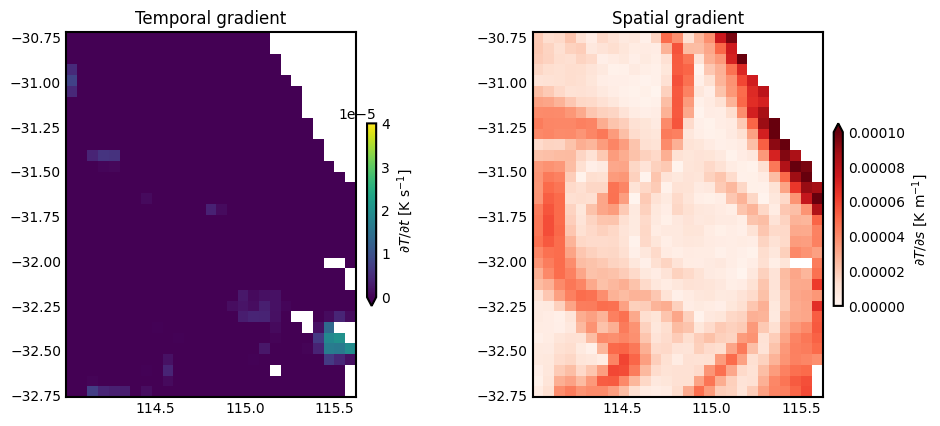

In [8]:
fig, ax = plots.plot_gradients(ds.isel(time=200), sg_names=['dTdx','dTdy'])

In [9]:
# ani = plots.plot_data_animation(ds, anim_interval=100)
# ani.save(f'{crop_app_mod}_data_full.mp4')

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [10]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(59, 'm').astype('timedelta64[ns]')

results_name = os.path.join(cropped_dir, f'{crop_app_mod}_fits_1h.nc')
# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=results_name, callback='off', coverage=0.7)

Running GP optimization


In [11]:
ds_results = xr.open_dataset(results_name)
ds_results.close()
ds_results

<xarray.Dataset> Size: 25kB
Dimensions:    (time: 288)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2026-01-22 ... 2026-02-02T23:00:00
Data variables:
    sigma_u    (time) float64 2kB ...
    l_u        (time) float64 2kB ...
    tau_u      (time) float64 2kB ...
    sigma_v    (time) float64 2kB ...
    l_v        (time) float64 2kB ...
    tau_v      (time) float64 2kB ...
    sigma_S    (time) float64 2kB ...
    l_S        (time) float64 2kB ...
    tau_S      (time) float64 2kB ...
    sigma_tau  (time) float64 2kB ...

In [12]:
print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds, ds_results, coverage=0.7)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
ds_full

Calculating GP regression prediction


<xarray.Dataset> Size: 11MB
Dimensions:    (time: 135, lat: 34, lon: 27)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2026-01-24T02:00:00 ... 2026-02-02T0...
  * lat        (lat) float64 272B -32.73 -32.67 -32.61 ... -30.87 -30.81 -30.75
  * lon        (lon) float64 216B 114.0 114.1 114.2 114.2 ... 115.5 115.5 115.6
    LON        (lat, lon) float64 7kB ...
    LAT        (lat, lon) float64 7kB ...
    X          (lat, lon) float64 7kB ...
    Y          (lat, lon) float64 7kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 991kB ...
    dTdt       (time, lat, lon) float64 991kB ...
    dTdx       (time, lat, lon) float64 991kB ...
    dTdy       (time, lat, lon) float64 991kB ...
    mu_u       (time, lat, lon) float64 991kB ...
    mu_v       (time, lat, lon) float64 991kB ...
    mu_S       (time, lat, lon) float64 991kB ...
    std_u      (time, lat, lon) float64 991kB ...
    std_v      (time, lat, lon) float64 991kB ...
    std_S      (time, lat, lon) float64 991kB ...
    K_uv       (time, lat, lon) float64 991kB ...

In [13]:
ds_results = ds_results.dropna(dim='time')
ds_results = utils.clean_dataset(ds_results)
ds_results_hourly = utils.make_even_hourly(ds_results.copy())

ds_full_hourly = utils.make_even_hourly(ds_full.copy())

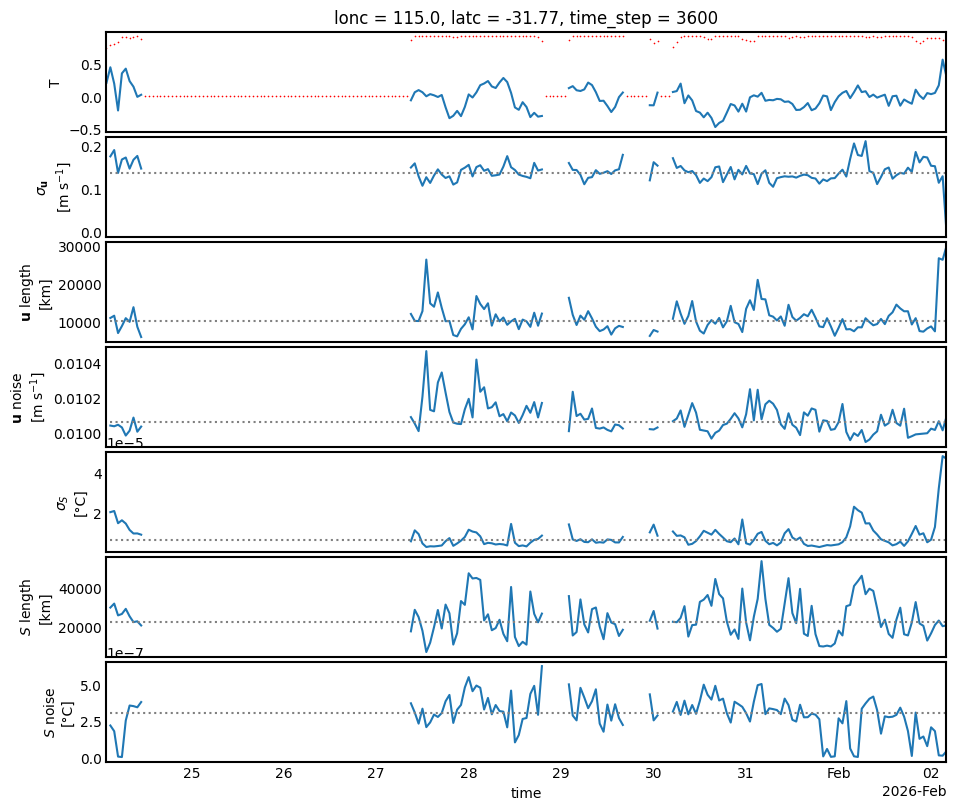

In [14]:
fig, ax = plots.plot_param_series(ds_full_hourly, ds_results_hourly)

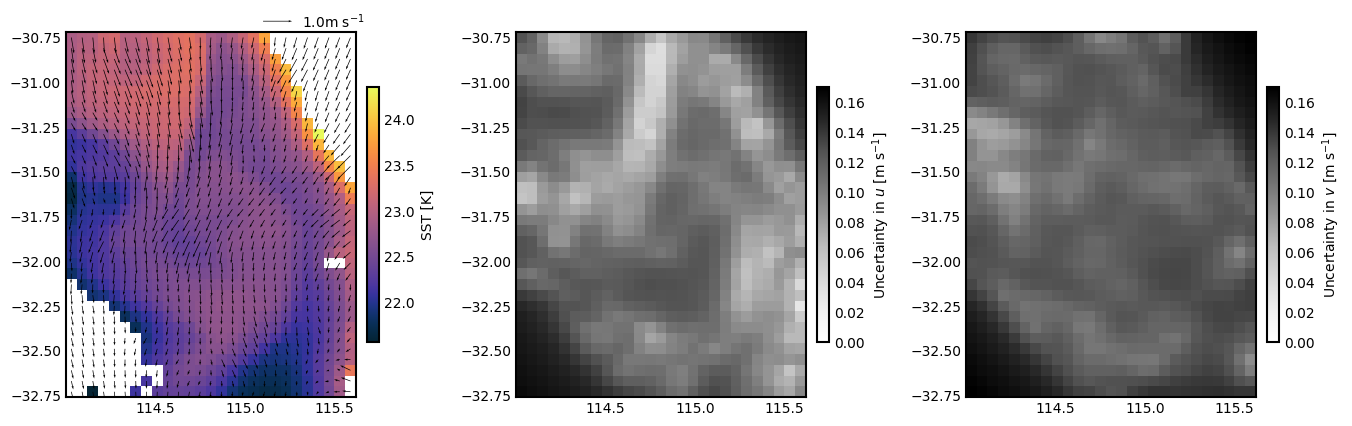

In [15]:
fig, ax = plots.plot_prediction(ds_full_hourly.isel(time=7*24), qv_scale=10, qk_size=1.)

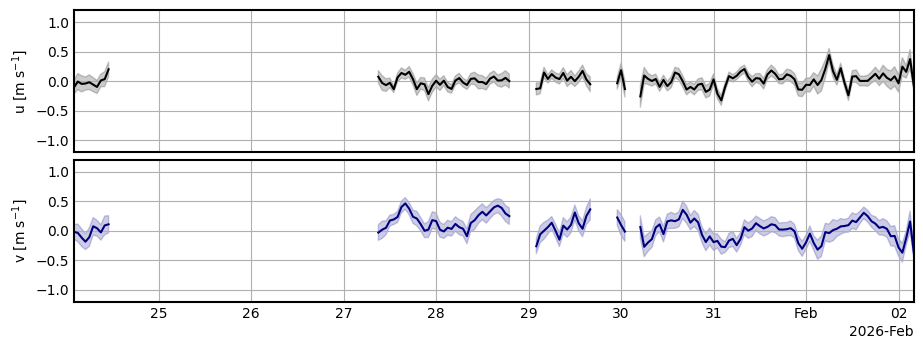

In [16]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=115.5, lat_pt=-31.75)
for x in ax:
    x.set_ylim(-1.21,1.21)
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

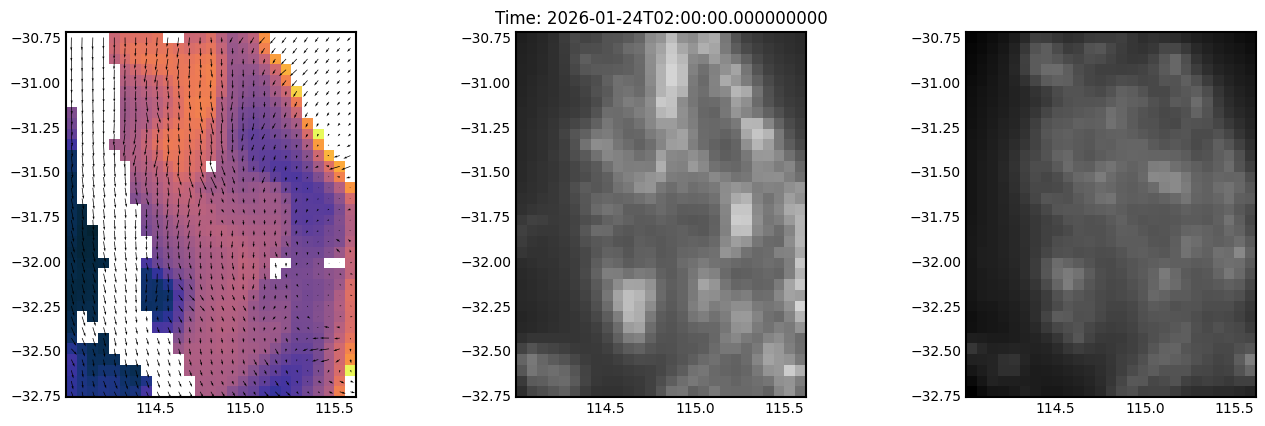

In [25]:
ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=14, anim_interval=100)
ani.save(f'{crop_app_mod}_animation_full.mp4')

## Some analysis

In [18]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

# Filter the SST inversion data
print(check_spacing(ds_full_hourly['time'].values))

# Remove bad fits
ds_full_hourly = ds_full_hourly.where(np.abs(ds_full_hourly['mu_u']) < 1.2)
ds_full_hourly = ds_full_hourly.where(np.abs(ds_full['mu_v']) < 1.2)

# # Fill missing time steps with zero
# full_time = pd.date_range(start=ds_full_hourly['time'].min().values, end=ds_full['time'].max().values, freq='h')
# ds_full = ds_full.reindex({'time': full_time}, fill_value=0)
# print(check_spacing(ds_full['time'].values))

ds_full_hourly['mu_u_lp'] = filter1d_xr(ds_full_hourly['mu_u'].fillna(0), 30, 60, ftype='lowpass', axis=0)
ds_full_hourly['mu_v_lp'] = filter1d_xr(ds_full_hourly['mu_v'].fillna(0), 30, 60, ftype='lowpass', axis=0)

True


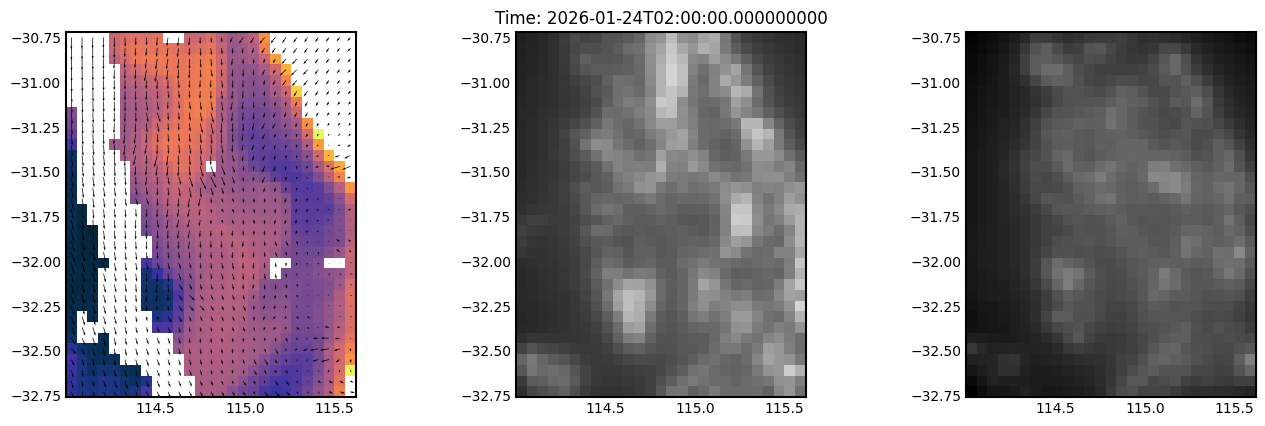

In [24]:
ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=15, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
ani.save(f'{crop_app_mod}_animation_lp60hr.mp4')

: 